[![open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1DSSHN_lRd0A_tPBwYBi6zlOd_9N1DBJ3#scrollTo=dpz7yKFTYXPZ)

## HW Requirement

• Rewrite the code of weight-tuning_EB to make the code of 
regularizing_EB.\
• Rewrite the code of weight-tuning_LG_UA to make the 
code of regularizing_LG_UA.\
• Rewrite the code of weight-tuning_EB_LG_UA to make the 
code of regularizing_EB_LG_UA.\
• Rewrite the code of weight-tuning_EB to make the code of 
regularizing_DO.\
• Rewrite the code of weight-tuning_EB to make the code of 
regularizing_BN.

## Model

In [1]:
import torch
from torch import nn, optim, Generator
from torch.utils.data import DataLoader, Dataset, random_split
from typing import Iterable, Callable, Type, Optional, Union, Tuple, List


c:\VS_Workplace\NN\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from operator import mul

def product(nums: Iterable[Type], func: Callable[[Type, Type], Type] = mul):
    def _product(nums):
        nonlocal func
        if len(nums) == 1:
            return nums[0]
        return func(nums[-1], _product(nums[:-1]))
    try:
        return _product(nums)
    except Exception as e:
        raise e

In [3]:
from collections import deque


class TwoLayerNetwork(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_classes: int, init_method: Callable, active_func: Callable[[], nn.modules.module.Module],
                 DO: float, if_BN: bool, store_size: int = 1):
        super(TwoLayerNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.if_BN = if_BN
        # dropout
        self.do = nn.Dropout(DO)
        # first layer
        self.fc1 = nn.Linear(input_size, hidden_size)
        # batch norm
        self.bn1 = nn.BatchNorm1d(hidden_size)
        # activation
        self.active_func = active_func()
        # second layer
        self.fc2 = nn.Linear(hidden_size, num_classes)
        # initialize
        for param in self.parameters():
            init_method(param)
        self.storage = deque(maxlen=store_size)

    def forward(self, x: Iterable[Union[torch.Tensor, float]]) -> torch.Tensor:
        out = self.do(x)
        out = self.fc1(out)
        if self.if_BN:
            out = self.bn1(out)
        out = self.active_func(out)
        out = self.fc2(out)
        return out


In [4]:
class WD_Regularization(nn.Module):
    def __init__(self):
        super(WD_Regularization, self).__init__()


class L2_Regularization(WD_Regularization):
    def __init__(self, weight_decay: float):
        super(L2_Regularization, self).__init__()
        if weight_decay <= 0:
            raise ValueError("param weight_decay can not <=0!!")
        self.weight_decay = weight_decay

    def forward(self, model: nn.Module) -> Union[torch.Tensor, float]:
        reg = 0
        for name, parameter in model.named_parameters():
            if "weight" in name:
                reg += torch.sum(parameter**2)
        return self.weight_decay * reg


In [5]:
def validate(model: nn.Module, device: str, valloader: DataLoader[Dataset[torch.Tensor]], criterion: nn.modules.loss._Loss) \
        -> Tuple[float, float]:
    """return loss, accuracy"""
    # Validate the model
    model.to(device)
    val_loss = 0.0
    val_correct = 0
    model.eval()
    with torch.no_grad():
        for X, y in valloader:
            X = X.view(-1, model.input_size).to(device)
            y = y.to(device)
            outputs = model(X)
            loss = criterion(outputs, y)
            val_loss += loss.item() * X.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == y).sum().item()
        val_loss /= len(valloader.dataset)
        val_accuracy = val_correct / len(valloader.dataset)
    return val_loss, val_accuracy


In [6]:
def train(model: TwoLayerNetwork, opt: Callable[..., optim.Optimizer], device: str, epochs: float, learning_rate: float, trainloader: DataLoader[Dataset[torch.Tensor]], valloader: DataLoader[Dataset[torch.Tensor]], criterion: nn.modules.loss._Loss,
          sched: Optional[Callable[[optim.Optimizer], optim.lr_scheduler._LRScheduler]], wd_reg: Optional[WD_Regularization], learning_goal: float, min_lr: float, if_lr_adjust: bool, if_BN: bool, drop_out: float) \
        -> List[Tuple[float, float, float, float]]:
    """
    Params:
        model
        opt
        device
        epochs
        learing_rate
        criterion
        y: label of data
        wd_reg, BN, DO: regularization
    Results:
        history: train_loss, train_accuracy, val_loss, val_accuracy of each epochs
    """
    def forward_backward(optimizer: optim.Optimizer, criterion: nn.modules.loss._Loss, wd_reg: Optional[WD_Regularization], model: TwoLayerNetwork, y: torch.Tensor,
                         BN: Optional[nn.modules.batchnorm._BatchNorm], DO: Optional[nn.modules.dropout._DropoutNd]) \
            -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Params:
            optimizer
            criterion
            model
            y: label of data
            wd_reg, BN, DO: regularization
        Results:
            ouputs: f(x)
            loss_all: f(x) - y
        """
        optimizer.zero_grad()
        outputs = model(X)
        outputs = outputs if not DO else DO(outputs)
        loss_all = criterion(
            outputs, y) + wd_reg(model) if wd_reg else criterion(outputs, y)
        loss_all.backward()
        optimizer.step()
        return loss_all, outputs

    if epochs < 1:
        raise ValueError("Invalid epoch!!")
    if drop_out >= 1 or drop_out < 0:
        raise ValueError("Invalid dropout rate!!")
    # init
    epoch = 0
    init_lr = learning_rate
    origin_if_BN = model.if_BN
    model.if_BN = if_BN
    pre_loss = float("inf") if if_lr_adjust else None
    BN = nn.BatchNorm1d(model.hidden_size).to(device) if if_BN else None
    DO = nn.Dropout(drop_out).to(device) if drop_out != 0. else None
    model.to(device)
    # if not model.storage[-1]
    model.storage.append(list(model.parameters()))
    optimizer = opt(model.storage[-1], lr=learning_rate)
    scheduler = sched(optimizer) if sched else None
    history = []
    # Train the model
    while epoch < epochs:
        # Train the model
        train_loss = 0.0
        train_correct = 0
        model.train()
        for X, y in trainloader:
            X = X.view(-1, model.input_size).to(device)
            y = y.to(device)
            loss_all, outputs = forward_backward(
                optimizer, criterion, wd_reg, model, y, BN, DO)
            if pre_loss:
                while pre_loss <= loss_all.item():
                    if learning_rate < min_lr:
                        # return history
                        learning_rate = init_lr
                        optimizer = opt(model.storage[-1], lr=learning_rate)
                        loss_all, outputs = forward_backward(
                            optimizer, criterion, wd_reg, model, y, BN, DO)
                        # raise ValueError(f"{learning_rate} < {min_lr}")
                        break
                    learning_rate *= 0.7
                    optimizer = opt(model.storage[-1], lr=learning_rate)
                    loss_all, outputs = forward_backward(
                        optimizer, criterion, wd_reg, model, y, BN, DO)
                learning_rate *= 1.2
                pre_loss = loss_all.item()
            train_loss += loss_all.item() * X.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_correct += (predicted == y).sum().item()
            model.storage.append(list(model.parameters()))
        train_loss /= len(trainloader.dataset)
        train_accuracy = train_correct / len(trainloader.dataset)
        # Validate the model
        val_loss, val_accuracy = validate(
            model=model, device=device, valloader=valloader, criterion=criterion)
        # Log Statics
        history.append((train_loss, train_accuracy, val_loss, val_accuracy))
        # Stopping criteria
        if learning_goal < val_accuracy:
            return history
        # Update loop
        if scheduler:
            scheduler.step()
        epoch += 1
    # restore model
    model.if_BN = origin_if_BN
    return history


In [7]:
def test(model: nn.Module, device: str, testloader: DataLoader[Dataset[torch.Tensor]]) -> float:
    """return accuracy"""
    return validate(model=model, device=device, valloader=testloader, criterion=nn.CrossEntropyLoss())[1]


# Dataset

### pytorch dataset

In [8]:
# load pytorch dataset
from torchvision import datasets, transforms


def getPytorchData(train: float = 0.8, remain: float = 0.1) \
    -> tuple[DataLoader[Dataset[torch.Tensor]], DataLoader[Dataset[torch.Tensor]], DataLoader[Dataset[torch.Tensor]], int, int]:
    """
    Params:
        train: train_amount / total_amount or 1 - valid_amount / total_amount
        remain: reduce data amount to save time
    Results:
        trainloader, valloader, testloader: dataloader
        datum_size: input size of NN
        class_amount: output size of NN
    """
    # preprocess: flatten, normalize, drop 90%, split
    transform = transforms.transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    if 0 >= train or train >= 1:
        raise ValueError()
    if 0 > remain or remain > 1:
        raise ValueError()
    # Split the training set into training and validation sets
    trainset = datasets.FashionMNIST(
        root="./data/", train=True, download=False, transform=transform)
    train_count = int(train * remain * len(trainset))
    valid_count = int((1 - train) * remain * len(trainset))
    if train_count * valid_count == 0:
        raise ValueError()
    datum_size = product(trainset[0][0].size())
    class_amount = len(trainset.classes)
    testset = datasets.FashionMNIST(
        root="./data/", train=False, download=False, transform=transform)
    print(train_count, valid_count, len(testset))
    trainset, valset, _ = random_split(
        trainset, (train_count, valid_count, len(trainset) - train_count - valid_count), Generator().manual_seed(42))
    # Create dataloaders to load the data in batches
    trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
    valloader = DataLoader(valset, batch_size=32, shuffle=True)
    testloader = DataLoader(testset, batch_size=32, shuffle=True)
    return trainloader, valloader, testloader, datum_size, class_amount


# Training

### setting

In [9]:
device = "cuda" if torch.cuda.is_available(
) else "mps" if torch.backends.mps.is_available() else "cpu"
trainloader, valloader, testloader, input_size, output_size = getPytorchData()
learning_rate = 0.001
weight_decay = 0.001
criterion = nn.CrossEntropyLoss()
lg = 0.82

4800 1199 10000


## model

### RG_EB_LG_UA_BN

In [10]:
hidden_size = 11
epochs = 300
init = lambda x: nn.init.xavier_uniform_(
    tensor=x) if len(x.shape) > 1 else None
active = nn.ReLU
model = TwoLayerNetwork(input_size, hidden_size,
                        output_size, init, active, 0.2, True)
optimize = optim.SGD
schedule = None
learning_goal = lg #
min_lr = learning_rate * 1e-5
l2_reg = L2_Regularization(weight_decay)
RG_EB_LG_UA_BN_DO_baseline = test(model, device, testloader)
RG_EB_LG_UA_BN_DO_history = train(model, optimize, device, epochs, learning_rate,
                   trainloader, valloader, criterion, schedule, l2_reg, learning_goal, min_lr, True, True, 0.2)
RG_EB_LG_UA_BN_DO_result = test(model, device, testloader)
print(RG_EB_LG_UA_BN_DO_baseline, RG_EB_LG_UA_BN_DO_history, RG_EB_LG_UA_BN_DO_result, sep="\n")

0.0862
[(2.259142078558604, 0.18625, 1.9780509599155938, 0.2627189324437031), (1.997987543741862, 0.29854166666666665, 1.7952045925067204, 0.4061718098415346), (1.8777892565727234, 0.34625, 1.7147342150563294, 0.44036697247706424), (1.7990923500061036, 0.38083333333333336, 1.6402873187586107, 0.4553794829024187), (1.7402167598406473, 0.41458333333333336, 1.5865710254904626, 0.5012510425354462), (1.6840766183535258, 0.4527083333333333, 1.509275524988087, 0.5462885738115096), (1.645756845474243, 0.48270833333333335, 1.4837465599440256, 0.5963302752293578), (1.6122274947166444, 0.5029166666666667, 1.4560852937642688, 0.6163469557964971), (1.55253573179245, 0.535625, 1.406929442542508, 0.6255212677231026), (1.521417731444041, 0.5558333333333333, 1.3457659065375436, 0.6597164303586321), (1.5050866882006326, 0.5479166666666667, 1.3473621840473013, 0.6422018348623854), (1.4710981607437135, 0.5672916666666666, 1.3214819621204634, 0.6680567139282736), (1.4556534298261006, 0.5702083333333333, 1.

In [11]:
model_path = r"./data/rg_eb_lg_ua_bn_do"
torch.save(model, model_path)

In [12]:
with open("./data/rg_eb_lg_ua_bn_do.txt", "w") as f:
    f.write(f"baseline: {RG_EB_LG_UA_BN_DO_baseline}\n")
    for epoch in range(len(RG_EB_LG_UA_BN_DO_history)):
        (trn_loss, trn_acc, val_loss, val_acc) = (
            RG_EB_LG_UA_BN_DO_history[epoch][0], RG_EB_LG_UA_BN_DO_history[epoch][1], RG_EB_LG_UA_BN_DO_history[epoch][2], RG_EB_LG_UA_BN_DO_history[epoch][3])
        f.write(
            f"trn_loss: {trn_loss}, trn_acc: {trn_acc}, val_loss: {val_loss}, val_acc: {val_acc}\n")
    f.write(f"result: {RG_EB_LG_UA_BN_DO_result}\n")


### RG_EB

In [13]:
hidden_size = 11
epochs = 300
init = lambda x: nn.init.xavier_uniform_(
    tensor=x) if len(x.shape) > 1 else None
active = nn.ReLU
model = TwoLayerNetwork(input_size, hidden_size,
                        output_size, init, active, 0.0, False)
optimize = optim.SGD
schedule = None  
learning_goal = 1. #
min_lr = learning_rate * 1e-5
l2_reg = L2_Regularization(weight_decay)
RG_EB_baseline = test(model, device, testloader)
RG_EB_history = train(model, optimize, device, epochs, learning_rate,
                   trainloader, valloader, criterion, schedule, l2_reg, learning_goal, min_lr, True, False, 0.0)
RG_EB_result = test(model, device, testloader)
print(RG_EB_baseline, RG_EB_history, RG_EB_result, sep="\n")


0.0506
[(2.17219793399175, 0.16791666666666666, 1.954293134512754, 0.24854045037531275), (1.8406341314315795, 0.35, 1.6843276861014218, 0.37447873227689743), (1.5798551591237386, 0.48104166666666665, 1.4037545820988646, 0.5571309424520434), (1.305793041785558, 0.6177083333333333, 1.1487301046198064, 0.6438698915763136), (1.1052719644705455, 0.6754166666666667, 0.9957884755902136, 0.6930775646371977), (0.9856431925296784, 0.7025, 0.9012095217311055, 0.7105921601334445), (0.9087858211994171, 0.7185416666666666, 0.8347695724381518, 0.731442869057548), (0.8547673801581065, 0.7341666666666666, 0.792396275474192, 0.7306088407005839), (0.8205044362942377, 0.743125, 0.7601432156523036, 0.7356130108423686), (0.7903749032815297, 0.7522916666666667, 0.7408222407972544, 0.7489574645537949), (0.7659900309642156, 0.7552083333333334, 0.7129113284919141, 0.7572977481234362), (0.7478205827871959, 0.7629166666666667, 0.6951134795442634, 0.7589658048373644), (0.7303350140651067, 0.7675, 0.682929635296472

In [14]:
with open("./data/rg_eb.txt", "w") as f:
    f.write(f"baseline: {RG_EB_baseline}\n")
    for epoch in range(len(RG_EB_history)):
        (trn_loss, trn_acc, val_loss, val_acc) = (
            RG_EB_history[epoch][0], RG_EB_history[epoch][1], RG_EB_history[epoch][2], RG_EB_history[epoch][3])
        f.write(
            f"trn_loss: {trn_loss}, trn_acc: {trn_acc}, val_loss: {val_loss}, val_acc: {val_acc}\n")
    f.write(f"result: {RG_EB_result}\n")


### RG_LG_UA

In [15]:
hidden_size = 11
epochs = float("inf")
init = lambda x: nn.init.xavier_uniform_(
    tensor=x) if len(x.shape) > 1 else None
active = nn.ReLU
model = TwoLayerNetwork(input_size, hidden_size,
                        output_size, init, active, 0.0, False)
optimize = optim.SGD
schedule = None
learning_goal = lg #
min_lr = learning_rate * 1e-5
l2_reg = L2_Regularization(weight_decay)
RG_LG_UA_baseline = test(model, device, testloader)
RG_LG_UA_history = train(model, optimize, device, epochs, learning_rate,
                   trainloader, valloader, criterion, schedule, l2_reg, learning_goal, min_lr, True, False, 0.0)
RG_LG_UA_result = test(model, device, testloader)
print(RG_LG_UA_baseline, RG_LG_UA_history, RG_LG_UA_result, sep="\n")


0.1228
[(2.023749837875366, 0.31645833333333334, 1.719809142622578, 0.4462051709758132), (1.6085715238253275, 0.47770833333333335, 1.391222895484253, 0.5454545454545454), (1.3087211736043294, 0.6302083333333334, 1.115434124332552, 0.6822351959966639), (1.084008960723877, 0.6970833333333334, 0.9390673157172565, 0.707256046705588), (0.9507125612099966, 0.729375, 0.8354927807474654, 0.731442869057548), (0.8633737369378408, 0.7466666666666667, 0.7700323315835973, 0.7514595496246872), (0.8106641505161921, 0.7602083333333334, 0.7298544015955984, 0.7489574645537949), (0.7728324321905772, 0.7620833333333333, 0.6908628733283386, 0.7723102585487907), (0.7430740368366241, 0.7697916666666667, 0.6801327448074176, 0.7723102585487907), (0.7181694940725962, 0.7754166666666666, 0.6561888989256858, 0.780650542118432), (0.7000415152311326, 0.7791666666666667, 0.6350421261747645, 0.7881567973311092), (0.6801739070812861, 0.7810416666666666, 0.6257323895622234, 0.7914929107589658), (0.6680640590190887, 0.7

In [16]:
with open("./data/rg_lg_ua.txt", "w") as f:
    f.write(f"baseline: {RG_LG_UA_baseline}\n")
    for epoch in range(len(RG_LG_UA_history)):
        (trn_loss, trn_acc, val_loss, val_acc) = (
            RG_LG_UA_history[epoch][0], RG_LG_UA_history[epoch][1], RG_LG_UA_history[epoch][2], RG_LG_UA_history[epoch][3])
        f.write(
            f"trn_loss: {trn_loss}, trn_acc: {trn_acc}, val_loss: {val_loss}, val_acc: {val_acc}\n")
    f.write(f"result: {RG_LG_UA_result}\n")


### RG_EB_LG_UA

In [17]:
hidden_size = 11
epochs = 300
init = lambda x: nn.init.xavier_uniform_(
    tensor=x) if len(x.shape) > 1 else None
active = nn.ReLU
model = TwoLayerNetwork(input_size, hidden_size,
                        output_size, init, active, 0.0, False)
optimize = optim.SGD
schedule = None
learning_goal = lg #
min_lr = learning_rate * 1e-5
l2_reg = L2_Regularization(weight_decay)
RG_EB_LG_UA_baseline = test(model, device, testloader)
RG_EB_LG_UA_history = train(model, optimize, device, epochs, learning_rate,
                   trainloader, valloader, criterion, schedule, l2_reg, learning_goal, min_lr, True, False, 0.0)
RG_EB_LG_UA_result = test(model, device, testloader)
print(RG_EB_LG_UA_baseline, RG_EB_LG_UA_history, RG_EB_LG_UA_result, sep="\n")


0.1601
[(2.0775944232940673, 0.261875, 1.837197868798155, 0.2902418682235196), (1.7026800441741943, 0.41833333333333333, 1.4905739656779247, 0.49958298582151794), (1.4022892061869303, 0.5652083333333333, 1.2315707987203908, 0.5946622185154296), (1.1879960350195566, 0.6345833333333334, 1.052923770125853, 0.683069224353628), (1.0404195137818655, 0.6922916666666666, 0.9365766407351777, 0.725604670558799), (0.9504377377033234, 0.7160416666666667, 0.860979281981057, 0.74395329441201), (0.8899887307484945, 0.728125, 0.8095667790730264, 0.7522935779816514), (0.8397329195340475, 0.7429166666666667, 0.7698509120463928, 0.762301918265221), (0.8054056525230407, 0.7533333333333333, 0.7391651401527729, 0.7723102585487907), (0.7745345338185629, 0.7608333333333334, 0.720323933920729, 0.762301918265221), (0.7522362347443898, 0.7629166666666667, 0.6900072621245301, 0.7856547122602169), (0.7290558874607086, 0.7685416666666667, 0.6798036307767593, 0.7756463719766472), (0.7117011630535126, 0.7720833333333

In [18]:
with open("./data/rg_eb_lg_ua.txt", "w") as f:
    f.write(f"baseline: {RG_EB_LG_UA_baseline}\n")
    for epoch in range(len(RG_EB_LG_UA_history)):
        (trn_loss, trn_acc, val_loss, val_acc) = (
            RG_EB_LG_UA_history[epoch][0], RG_EB_LG_UA_history[epoch][1], RG_EB_LG_UA_history[epoch][2], RG_EB_LG_UA_history[epoch][3])
        f.write(
            f"trn_loss: {trn_loss}, trn_acc: {trn_acc}, val_loss: {val_loss}, val_acc: {val_acc}\n")
    f.write(f"result: {RG_EB_LG_UA_result}\n")


### RG_BN

In [19]:
hidden_size = 11
epochs = 300
init = lambda x: nn.init.xavier_uniform_(
    tensor=x) if len(x.shape) > 1 else None
active = nn.ReLU
model = TwoLayerNetwork(input_size, hidden_size,
                        output_size, init, active, 0.0, True)
optimize = optim.SGD
schedule = None
learning_goal = lg #
min_lr = learning_rate * 1e-5
l2_reg = None
RG_BN_baseline = test(model, device, testloader)
RG_BN_history = train(model, optimize, device, epochs, learning_rate,
                   trainloader, valloader, criterion, schedule, l2_reg, learning_goal, min_lr, False, True, 0.0)
RG_BN_result = test(model, device, testloader)
print(RG_BN_baseline, RG_BN_history, RG_BN_result, sep="\n")


0.0556
[(2.3267716932296754, 0.153125, 2.073223311071897, 0.27606338615512926), (1.9661941353480021, 0.35104166666666664, 1.8599323709374969, 0.43119266055045874), (1.8257954629262287, 0.45458333333333334, 1.7498363993185773, 0.4962468723936614), (1.7377185575167338, 0.49020833333333336, 1.6661717730626353, 0.530442035029191), (1.6780819137891134, 0.5204166666666666, 1.6055346862587758, 0.5571309424520434), (1.6234658630688985, 0.540625, 1.5592095934420054, 0.5754795663052544), (1.579879702727, 0.5610416666666667, 1.5150391589213252, 0.5946622185154296), (1.5418644293149313, 0.5685416666666666, 1.4822459217903512, 0.6046705587989991), (1.5036148564020793, 0.5835416666666666, 1.4334295152921892, 0.6055045871559633), (1.474041109085083, 0.59375, 1.4043269605811584, 0.6263552960800667), (1.439192340373993, 0.6058333333333333, 1.3797517409416116, 0.6296914095079232), (1.4144450124104817, 0.6233333333333333, 1.3377014735621944, 0.6513761467889908), (1.3879868586858113, 0.6291666666666667, 1

In [20]:
with open("./data/rg_bn.txt", "w") as f:
    f.write(f"baseline: {RG_BN_baseline}\n")
    for epoch in range(len(RG_BN_history)):
        (trn_loss, trn_acc, val_loss, val_acc) = (
            RG_BN_history[epoch][0], RG_BN_history[epoch][1], RG_BN_history[epoch][2], RG_BN_history[epoch][3])
        f.write(
            f"trn_loss: {trn_loss}, trn_acc: {trn_acc}, val_loss: {val_loss}, val_acc: {val_acc}\n")
    f.write(f"result: {RG_BN_result}\n")


### RG_DO

In [21]:
hidden_size = 11
epochs = 300
init = lambda x: nn.init.xavier_uniform_(
    tensor=x) if len(x.shape) > 1 else None
active = nn.ReLU
model = TwoLayerNetwork(input_size, hidden_size,
                        output_size, init, active, 0.2, False)
optimize = optim.SGD
schedule = None
learning_goal = lg #
min_lr = learning_rate * 1e-5
l2_reg = None
RG_DO_baseline = test(model, device, testloader)
RG_DO_history = train(model, optimize, device, epochs, learning_rate,
                   trainloader, valloader, criterion, schedule, l2_reg, learning_goal, min_lr, False, False, 0.2)
RG_DO_result = test(model, device, testloader)
print(RG_DO_baseline, RG_DO_history, RG_DO_result, sep="\n")


0.1375
[(2.333610192934672, 0.16208333333333333, 2.125658500781151, 0.2493744787322769), (2.1346313015619915, 0.22708333333333333, 1.980301106741669, 0.29608006672226855), (2.036772338549296, 0.2654166666666667, 1.8835285684284913, 0.3286071726438699), (1.957965407371521, 0.28979166666666667, 1.8079895727628466, 0.3561301084236864), (1.9130594730377197, 0.30895833333333333, 1.735369081890911, 0.38448707256046705), (1.8656727957725525, 0.3275, 1.668032025972737, 0.41201000834028356), (1.8160064164797465, 0.3514583333333333, 1.6024945992246282, 0.46788990825688076), (1.7596602312723795, 0.3854166666666667, 1.5446516673101596, 0.493744787322769), (1.7188194179534912, 0.406875, 1.4905975346171527, 0.517931609674729), (1.676894211769104, 0.429375, 1.439170728234871, 0.5521267723102585), (1.6339377323786417, 0.444375, 1.391770215110047, 0.5638031693077564), (1.5934990819295247, 0.46875, 1.3445639990089933, 0.5938281901584654), (1.561946881612142, 0.47708333333333336, 1.3022212199711423, 0.59

In [22]:
with open("./data/rg_do.txt", "w") as f:
    f.write(f"baseline: {RG_DO_baseline}\n")
    for epoch in range(len(RG_DO_history)):
        (trn_loss, trn_acc, val_loss, val_acc) = (
            RG_DO_history[epoch][0], RG_DO_history[epoch][1], RG_DO_history[epoch][2], RG_DO_history[epoch][3])
        f.write(
            f"trn_loss: {trn_loss}, trn_acc: {trn_acc}, val_loss: {val_loss}, val_acc: {val_acc}\n")
    f.write(f"result: {RG_DO_result}\n")


## regulariztion

### r_eb

In [23]:
hidden_size = 11
epochs = 50
init = lambda x: nn.init.xavier_uniform_(
    tensor=x) if len(x.shape) > 1 else None
active = nn.ReLU
model = torch.load(model_path)
optimize = optim.SGD
schedule = None
learning_goal = 1.
min_lr = learning_rate * 1e-5
l2_reg = L2_Regularization(weight_decay)
r_EB_baseline = test(model, device, testloader)
r_EB_history = train(model, optimize, device, epochs, learning_rate,
                     trainloader, valloader, criterion, schedule, l2_reg, learning_goal, min_lr, False, False, 0.0)
r_EB_result = test(model, device, testloader)
print(r_EB_baseline, r_EB_history, r_EB_result, sep="\n")


0.798
[(0.7645416257778803, 0.7558333333333334, 0.565469590150087, 0.804837364470392), (0.6375752619902293, 0.7983333333333333, 0.5383192759637936, 0.8115095913261051), (0.6150938552618027, 0.7966666666666666, 0.5298548999232386, 0.8140116763969975), (0.6153746525446574, 0.796875, 0.5255996714143379, 0.817347789824854), (0.6036502480506897, 0.8058333333333333, 0.5245273991412576, 0.8181818181818182), (0.6026977078119914, 0.80375, 0.5204932269600653, 0.8206839032527106), (0.5927669074138006, 0.801875, 0.5181112916296576, 0.8223519599666389), (0.5989356615146001, 0.8010416666666667, 0.5193153906852828, 0.8198498748957465), (0.5932485332091649, 0.8058333333333333, 0.5167946307185891, 0.8198498748957465), (0.5954593723018964, 0.8033333333333333, 0.5163877853336087, 0.8223519599666389), (0.5935766704877218, 0.8020833333333334, 0.5166294642842939, 0.8215179316096747), (0.5831909130016962, 0.811875, 0.510413604045133, 0.8248540450375312), (0.5919424627224604, 0.804375, 0.5121221939059871, 0.8

In [24]:
with open("./data/r_eb.txt", "w") as f:
    f.write(f"baseline: {r_EB_baseline}\n")
    for epoch in range(len(r_EB_history)):
        (trn_loss, trn_acc, val_loss, val_acc) = (
            r_EB_history[epoch][0], r_EB_history[epoch][1], r_EB_history[epoch][2], r_EB_history[epoch][3])
        f.write(
            f"trn_loss: {trn_loss}, trn_acc: {trn_acc}, val_loss: {val_loss}, val_acc: {val_acc}\n")
    f.write(f"result: {r_EB_result}\n")


### r_LG_UA

In [25]:
hidden_size = 11
epochs = float("inf")
init = lambda x: nn.init.xavier_uniform_(
    tensor=x) if len(x.shape) > 1 else None
active = nn.ReLU
model = torch.load(model_path)
optimize = optim.SGD
schedule = None
learning_goal = lg #
min_lr = learning_rate * 1e-5
l2_reg = L2_Regularization(weight_decay)
r_LG_UA_baseline = test(model, device, testloader)
r_LG_UA_history = train(model, optimize, device, epochs, learning_rate,
                   trainloader, valloader, criterion, schedule, l2_reg, learning_goal, min_lr, True, False, 0.0)
r_LG_UA_result = test(model, device, testloader)
print(r_LG_UA_baseline, r_LG_UA_history, r_LG_UA_result, sep="\n")


0.798
[(0.6696934986114502, 0.7841666666666667, 0.5368731905759823, 0.8190158465387823), (0.5859755184253057, 0.811875, 0.5256327625559806, 0.8198498748957465), (0.5822787557045619, 0.8135416666666667, 0.5261764353369554, 0.817347789824854), (0.5787910046180089, 0.8152083333333333, 0.5244887146579911, 0.8198498748957465), (0.5746919886271159, 0.8097916666666667, 0.5143460446939159, 0.8223519599666389)]
0.8022


In [26]:
with open("./data/r_lg_ua.txt", "w") as f:
    f.write(f"baseline: {r_LG_UA_baseline}\n")
    for epoch in range(len(r_LG_UA_history)):
        (trn_loss, trn_acc, val_loss, val_acc) = (
            r_LG_UA_history[epoch][0], r_LG_UA_history[epoch][1], r_LG_UA_history[epoch][2], r_LG_UA_history[epoch][3])
        f.write(
            f"trn_loss: {trn_loss}, trn_acc: {trn_acc}, val_loss: {val_loss}, val_acc: {val_acc}\n")
    f.write(f"result: {r_LG_UA_result}\n")


### r_EB_LG_UA

In [27]:
hidden_size = 11
epochs = 50
init = lambda x: nn.init.xavier_uniform_(
    tensor=x) if len(x.shape) > 1 else None
active = nn.ReLU
model = torch.load(model_path)
optimize = optim.SGD
schedule = None
learning_goal = lg #
min_lr = learning_rate * 1e-5
l2_reg = L2_Regularization(weight_decay)
r_EB_LG_UA_baseline = test(model, device, testloader)
r_EB_LG_UA_history = train(model, optimize, device, epochs, learning_rate,
                   trainloader, valloader, criterion, schedule, l2_reg, learning_goal, min_lr, True, False, 0.0)
r_EB_LG_UA_result = test(model, device, testloader)
print(r_EB_LG_UA_baseline, r_EB_LG_UA_history, r_EB_LG_UA_result, sep="\n")


0.798
[(0.6675991572936376, 0.78875, 0.5402313362468373, 0.8140116763969975), (0.5938221921523412, 0.809375, 0.5283705594143935, 0.8198498748957465), (0.5835203071435292, 0.808125, 0.5208851421396369, 0.823185988323603)]
0.8029


In [28]:
with open("./data/r_eb_lg_ua.txt", "w") as f:
    f.write(f"baseline: {r_EB_LG_UA_baseline}\n")
    for epoch in range(len(r_EB_LG_UA_history)):
        (trn_loss, trn_acc, val_loss, val_acc) = (
            r_EB_LG_UA_history[epoch][0], r_EB_LG_UA_history[epoch][1], r_EB_LG_UA_history[epoch][2], r_EB_LG_UA_history[epoch][3])
        f.write(
            f"trn_loss: {trn_loss}, trn_acc: {trn_acc}, val_loss: {val_loss}, val_acc: {val_acc}\n")
    f.write(f"result: {r_EB_LG_UA_result}\n")


### r_BN

In [29]:
hidden_size = 11
epochs = 50
init = lambda x: nn.init.xavier_uniform_(
    tensor=x) if len(x.shape) > 1 else None
active = nn.ReLU
model = torch.load(model_path)
optimize = optim.SGD
schedule = None
learning_goal = lg #
min_lr = learning_rate * 1e-5
l2_reg = None
r_BN_baseline = test(model, device, testloader)
r_BN_history = train(model, optimize, device, epochs, learning_rate,
                   trainloader, valloader, criterion, schedule, l2_reg, learning_goal, min_lr, False, True, 0.0)
r_BN_result = test(model, device, testloader)
print(r_BN_baseline, r_BN_history, r_BN_result, sep="\n")


0.798
[(0.6599731055895487, 0.7879166666666667, 0.5958616776303315, 0.817347789824854), (0.658424034913381, 0.7854166666666667, 0.5975121433184085, 0.817347789824854), (0.6626862583557764, 0.7845833333333333, 0.5918239358069998, 0.8165137614678899), (0.6437529091040294, 0.78875, 0.5927486696573374, 0.8148457047539617), (0.6477145890394846, 0.7885416666666667, 0.5894260371695765, 0.8223519599666389)]
0.7998


In [30]:
with open("./data/r_bn.txt", "w") as f:
    f.write(f"baseline: {r_BN_baseline}\n")
    for epoch in range(len(r_BN_history)):
        (trn_loss, trn_acc, val_loss, val_acc) = (
            r_BN_history[epoch][0], r_BN_history[epoch][1], r_BN_history[epoch][2], r_BN_history[epoch][3])
        f.write(
            f"trn_loss: {trn_loss}, trn_acc: {trn_acc}, val_loss: {val_loss}, val_acc: {val_acc}\n")
    f.write(f"result: {r_BN_result}\n")


### r_DO

In [31]:
hidden_size = 11
epochs = 50
init = lambda x: nn.init.xavier_uniform_(
    tensor=x) if len(x.shape) > 1 else None
active = nn.ReLU
model = torch.load(model_path)
optimize = optim.SGD
schedule = None
learning_goal = lg #
min_lr = learning_rate * 1e-5
l2_reg = None
r_DO_baseline = test(model, device, testloader)
r_DO_history = train(model, optimize, device, epochs, learning_rate,
                   trainloader, valloader, criterion, schedule, l2_reg, learning_goal, min_lr, False, False, 0.2)
r_DO_result = test(model, device, testloader)
print(r_DO_baseline, r_DO_history, r_DO_result, sep="\n")


0.798
[(1.0033858700593312, 0.6420833333333333, 0.5737361008172437, 0.8073394495412844), (0.8168156822522481, 0.69125, 0.5568601020780377, 0.8065054211843202), (0.812348916331927, 0.6902083333333333, 0.5508193157184512, 0.8098415346121768), (0.805435122847557, 0.693125, 0.5470319064683572, 0.8115095913261051), (0.8247957402467727, 0.678125, 0.5407403360763324, 0.8181818181818182), (0.8014952754974365, 0.6964583333333333, 0.536504733602239, 0.8215179316096747)]
0.8006


In [32]:
with open("./data/r_do.txt", "w") as f:
    f.write(f"baseline: {r_DO_baseline}\n")
    for epoch in range(len(r_DO_history)):
        (trn_loss, trn_acc, val_loss, val_acc) = (
            r_DO_history[epoch][0], r_DO_history[epoch][1], r_DO_history[epoch][2], r_DO_history[epoch][3])
        f.write(
            f"trn_loss: {trn_loss}, trn_acc: {trn_acc}, val_loss: {val_loss}, val_acc: {val_acc}\n")
    f.write(f"result: {r_DO_result}\n")


## comparison

In [33]:
from matplotlib import pyplot as plt
import re


In [34]:
with open("./data/r_eb.txt", "r") as f:
    lines = f.readlines()[1:-1]
    r_EB_history = [[float(e) for e in re.sub(r"[a-z:,_]", " ", l).split()]
                  for l in lines]
print(r_EB_history)

[[0.7645416257778803, 0.7558333333333334, 0.565469590150087, 0.804837364470392], [0.6375752619902293, 0.7983333333333333, 0.5383192759637936, 0.8115095913261051], [0.6150938552618027, 0.7966666666666666, 0.5298548999232386, 0.8140116763969975], [0.6153746525446574, 0.796875, 0.5255996714143379, 0.817347789824854], [0.6036502480506897, 0.8058333333333333, 0.5245273991412576, 0.8181818181818182], [0.6026977078119914, 0.80375, 0.5204932269600653, 0.8206839032527106], [0.5927669074138006, 0.801875, 0.5181112916296576, 0.8223519599666389], [0.5989356615146001, 0.8010416666666667, 0.5193153906852828, 0.8198498748957465], [0.5932485332091649, 0.8058333333333333, 0.5167946307185891, 0.8198498748957465], [0.5954593723018964, 0.8033333333333333, 0.5163877853336087, 0.8223519599666389], [0.5935766704877218, 0.8020833333333334, 0.5166294642842939, 0.8215179316096747], [0.5831909130016962, 0.811875, 0.510413604045133, 0.8248540450375312], [0.5919424627224604, 0.804375, 0.5121221939059871, 0.8240200

In [35]:
with open("./data/r_lg_ua.txt", "r") as f:
    lines = f.readlines()[1:-1]
    r_LG_UA_history = [[float(e) for e in re.sub(
        r"[a-z:,_]", " ", l).split()] for l in lines]
print(r_LG_UA_history)


[[0.6696934986114502, 0.7841666666666667, 0.5368731905759823, 0.8190158465387823], [0.5859755184253057, 0.811875, 0.5256327625559806, 0.8198498748957465], [0.5822787557045619, 0.8135416666666667, 0.5261764353369554, 0.817347789824854], [0.5787910046180089, 0.8152083333333333, 0.5244887146579911, 0.8198498748957465], [0.5746919886271159, 0.8097916666666667, 0.5143460446939159, 0.8223519599666389]]


In [36]:
with open("./data/r_eb_lg_ua.txt", "r") as f:
    lines = f.readlines()[1:-1]
    r_EB_LG_UA_history = [[float(e) for e in re.sub(
        r"[a-z:,_]", " ", l).split()] for l in lines]
print(r_EB_LG_UA_history)


[[0.6675991572936376, 0.78875, 0.5402313362468373, 0.8140116763969975], [0.5938221921523412, 0.809375, 0.5283705594143935, 0.8198498748957465], [0.5835203071435292, 0.808125, 0.5208851421396369, 0.823185988323603]]


In [37]:
with open("./data/r_do.txt", "r") as f:
    lines = f.readlines()[1:-1]
    r_DO_history = [[float(e) for e in re.sub(r"[a-z:,_]", " ", l).split()]
                  for l in lines]
print(r_DO_history)

[[1.0033858700593312, 0.6420833333333333, 0.5737361008172437, 0.8073394495412844], [0.8168156822522481, 0.69125, 0.5568601020780377, 0.8065054211843202], [0.812348916331927, 0.6902083333333333, 0.5508193157184512, 0.8098415346121768], [0.805435122847557, 0.693125, 0.5470319064683572, 0.8115095913261051], [0.8247957402467727, 0.678125, 0.5407403360763324, 0.8181818181818182], [0.8014952754974365, 0.6964583333333333, 0.536504733602239, 0.8215179316096747]]


In [38]:
with open("./data/r_bn.txt", "r") as f:
    lines = f.readlines()[1:-1]
    r_BN_history = [[float(e) for e in re.sub(r"[a-z:,_]", " ", l).split()]
                  for l in lines]
print(r_BN_history)

[[0.6599731055895487, 0.7879166666666667, 0.5958616776303315, 0.817347789824854], [0.658424034913381, 0.7854166666666667, 0.5975121433184085, 0.817347789824854], [0.6626862583557764, 0.7845833333333333, 0.5918239358069998, 0.8165137614678899], [0.6437529091040294, 0.78875, 0.5927486696573374, 0.8148457047539617], [0.6477145890394846, 0.7885416666666667, 0.5894260371695765, 0.8223519599666389]]


In [39]:
x = range(len(r_EB_history))
x1 = range(len(r_LG_UA_history))
x2 = range(len(r_EB_LG_UA_history))
x3 = range(len(r_BN_history))
x4 = range(len(r_DO_history))

In [40]:
lg = 0.82


### loss

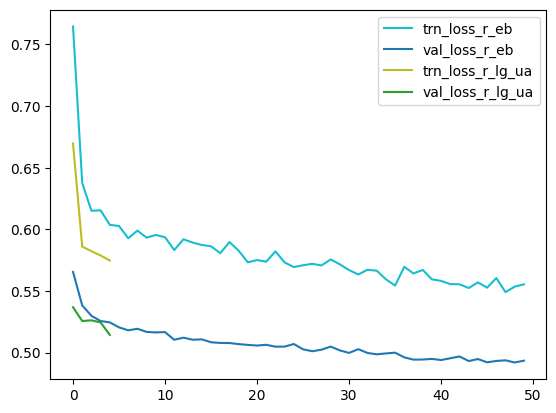

In [41]:
plt.plot(x, [e[0] for e in r_EB_history], "tab:cyan", label="trn_loss_r_eb")
plt.plot(x, [e[2] for e in r_EB_history], "tab:blue", label="val_loss_r_eb")
plt.plot(x1, [e[0] for e in r_LG_UA_history], "tab:olive", label="trn_loss_r_lg_ua")
plt.plot(x1, [e[2] for e in r_LG_UA_history], "tab:green", label="val_loss_r_lg_ua")
# plt.plot(x2, [e[0] for e in r_EB_LG_UA_history], "tab:orange", label="trn_loss_r_eb_lg_ua")
# plt.plot(x2, [e[2] for e in r_EB_LG_UA_history], "tab:red", label="val_loss_r_eb_lg_ua")
plt.legend(loc="upper right")
plt.show()


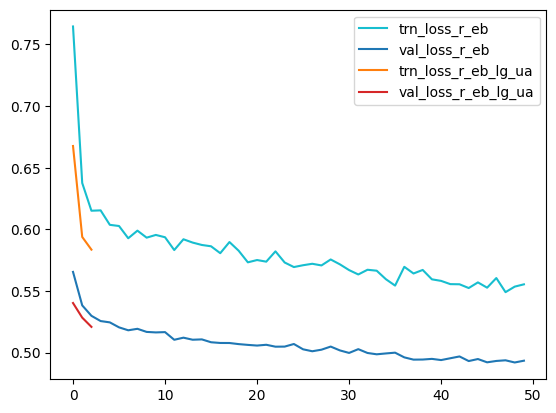

In [42]:
plt.plot(x, [e[0] for e in r_EB_history], "tab:cyan", label="trn_loss_r_eb")
plt.plot(x, [e[2] for e in r_EB_history], "tab:blue", label="val_loss_r_eb")
plt.plot(x2, [e[0] for e in r_EB_LG_UA_history], "tab:orange", label="trn_loss_r_eb_lg_ua")
plt.plot(x2, [e[2] for e in r_EB_LG_UA_history], "tab:red", label="val_loss_r_eb_lg_ua")
plt.legend(loc="upper right")
plt.show()


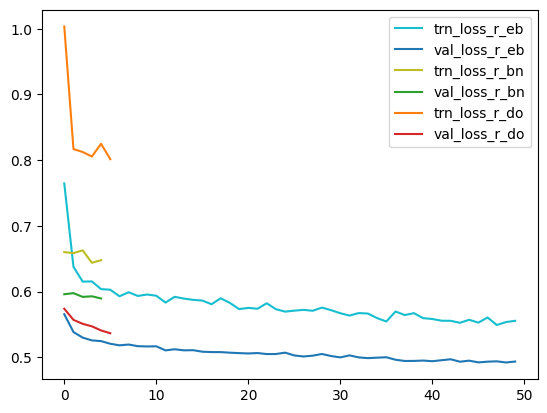

In [43]:
plt.plot(x, [e[0] for e in r_EB_history], "tab:cyan", label="trn_loss_r_eb")
plt.plot(x, [e[2] for e in r_EB_history], "tab:blue", label="val_loss_r_eb")
plt.plot(x3, [e[0] for e in r_BN_history], "tab:olive", label="trn_loss_r_bn")
plt.plot(x3, [e[2] for e in r_BN_history], "tab:green", label="val_loss_r_bn")
plt.plot(x4, [e[0] for e in r_DO_history], "tab:orange", label="trn_loss_r_do")
plt.plot(x4, [e[2] for e in r_DO_history], "tab:red", label="val_loss_r_do")
plt.legend(loc="upper right")
plt.show()


### accuracy

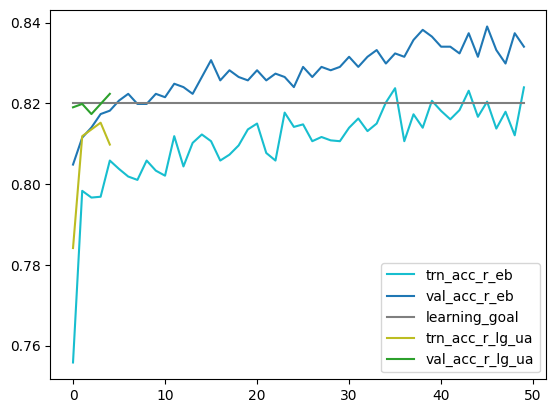

In [44]:
plt.plot(x, [e[1] for e in r_EB_history], "tab:cyan", label="trn_acc_r_eb")
plt.plot(x, [e[3] for e in r_EB_history], "tab:blue", label="val_acc_r_eb")
plt.plot(x, [lg for _ in x], "tab:gray", label="learning_goal")
plt.plot(x1, [e[1] for e in r_LG_UA_history], "tab:olive", label="trn_acc_r_lg_ua")
plt.plot(x1, [e[3] for e in r_LG_UA_history], "tab:green", label="val_acc_r_lg_ua")
# plt.plot(x2, [e[0] for e in r_EB_LG_UA_history], "tab:orange", label="trn_acc_r_eb_lg_ua")
# plt.plot(x2, [e[2] for e in r_EB_LG_UA_history], "tab:red", label="val_acc_r_eb_lg_ua")
plt.legend(loc="lower right")
plt.show()


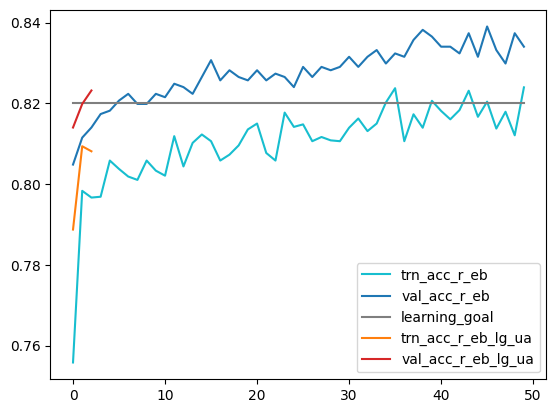

In [45]:
plt.plot(x, [e[1] for e in r_EB_history], "tab:cyan", label="trn_acc_r_eb")
plt.plot(x, [e[3] for e in r_EB_history], "tab:blue", label="val_acc_r_eb")
plt.plot(x, [lg for _ in x], "tab:gray", label="learning_goal")
plt.plot(x2, [e[1] for e in r_EB_LG_UA_history], "tab:orange", label="trn_acc_r_eb_lg_ua")
plt.plot(x2, [e[3] for e in r_EB_LG_UA_history], "tab:red", label="val_acc_r_eb_lg_ua")
plt.legend(loc="lower right")
plt.show()


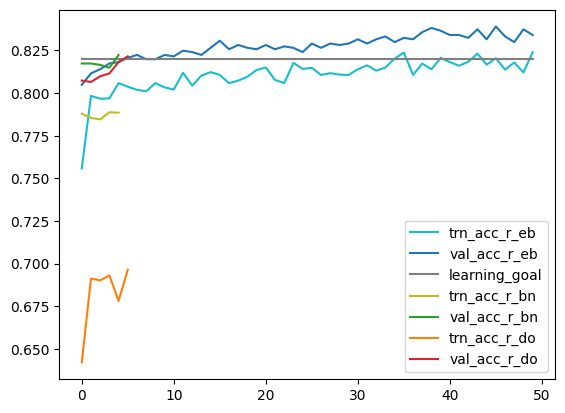

In [46]:
plt.plot(x, [e[1] for e in r_EB_history], "tab:cyan", label="trn_acc_r_eb")
plt.plot(x, [e[3] for e in r_EB_history], "tab:blue", label="val_acc_r_eb")
plt.plot(x, [lg for _ in x], "tab:gray", label="learning_goal")
plt.plot(x3, [e[1] for e in r_BN_history], "tab:olive", label="trn_acc_r_bn")
plt.plot(x3, [e[3] for e in r_BN_history], "tab:green", label="val_acc_r_bn")
plt.plot(x4, [e[1] for e in r_DO_history], "tab:orange", label="trn_acc_r_do")
plt.plot(x4, [e[3] for e in r_DO_history], "tab:red", label="val_acc_r_do")
plt.legend(loc="lower right")
plt.show()
